In [1]:
import tqdm
import pandas as pd
import torch
import seaborn as sns
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


### データの読み込み
表形式のデータを扱うのに長けた，pandasでデータを読み込む。
pandasにはread_csv()やread_excel()関数があり，一般的な表形式データをそのまま読み込むことができる。

In [2]:
df = pd.read_csv("./data/CarPrice_Assignment.csv")

Jupyter Notebook形式でスクリプトを書いている場合，セルの最終行に変数名だけを記載した場合，その内容が表示される。
その他の場所で表示がしたい場合はprint()関数の使用が必要

In [3]:
df

car_ID  symboling                   CarName fueltype aspiration  \
0         1          3        alfa-romero giulia      gas        std   
1         2          3       alfa-romero stelvio      gas        std   
2         3          1  alfa-romero Quadrifoglio      gas        std   
3         4          2               audi 100 ls      gas        std   
4         5          2                audi 100ls      gas        std   
..      ...        ...                       ...      ...        ...   
200     201         -1           volvo 145e (sw)      gas        std   
201     202         -1               volvo 144ea      gas      turbo   
202     203         -1               volvo 244dl      gas        std   
203     204         -1                 volvo 246   diesel      turbo   
204     205         -1               volvo 264gl      gas      turbo   

    doornumber      carbody drivewheel enginelocation  wheelbase  ...  \
0          two  convertible        rwd          front       88.6  ...   
1          two  convertible        rwd          front       88.6  ...   
2          two    hatchback        rwd          front       94.5  ...   
3         four        sedan        fwd          front       99.8  ...   
4         four        sedan        4wd          front       99.4  ...   
..         ...          ...        ...            ...        ...  ...   
200       four        sedan        rwd          front      109.1  ...   
201       four        sedan        rwd          front      109.1  ...   
202       four        sedan        rwd          front      109.1  ...   
203       four        sedan        rwd          front      109.1  ...   
204       four        sedan        rwd          front      109.1  ...   

     enginesize  fuelsystem  boreratio  stroke compressionratio horsepower  \
0           130        mpfi       3.47    2.68              9.0        111   
1           130        mpfi       3.47    2.68              9.0        111   
2           152        mpfi       2.68    3.47              9.0        154   
3           109        mpfi       3.19    3.40             10.0        102   
4           136        mpfi       3.19    3.40              8.0        115   
..          ...         ...        ...     ...              ...        ...   
200         141        mpfi       3.78    3.15              9.5        114   
201         141        mpfi       3.78    3.15              8.7        160   
202         173        mpfi       3.58    2.87              8.8        134   
203         145         idi       3.01    3.40             23.0        106   
204         141        mpfi       3.78    3.15              9.5        114   

     peakrpm citympg  highwaympg    price  
0       5000      21          27  13495.0  
1       5000      21          27  16500.0  
2       5000      19          26  16500.0  
3       5500      24          30  13950.0  
4       5500      18          22  17450.0  
..       ...     ...         ...      ...  
200     5400      23          28  16845.0  
201     5300      19          25  19045.0  
202     5500      18          23  21485.0  
203     4800      26          27  22470.0  
204     5400      19          25  22625.0  

[205 rows x 26 columns]

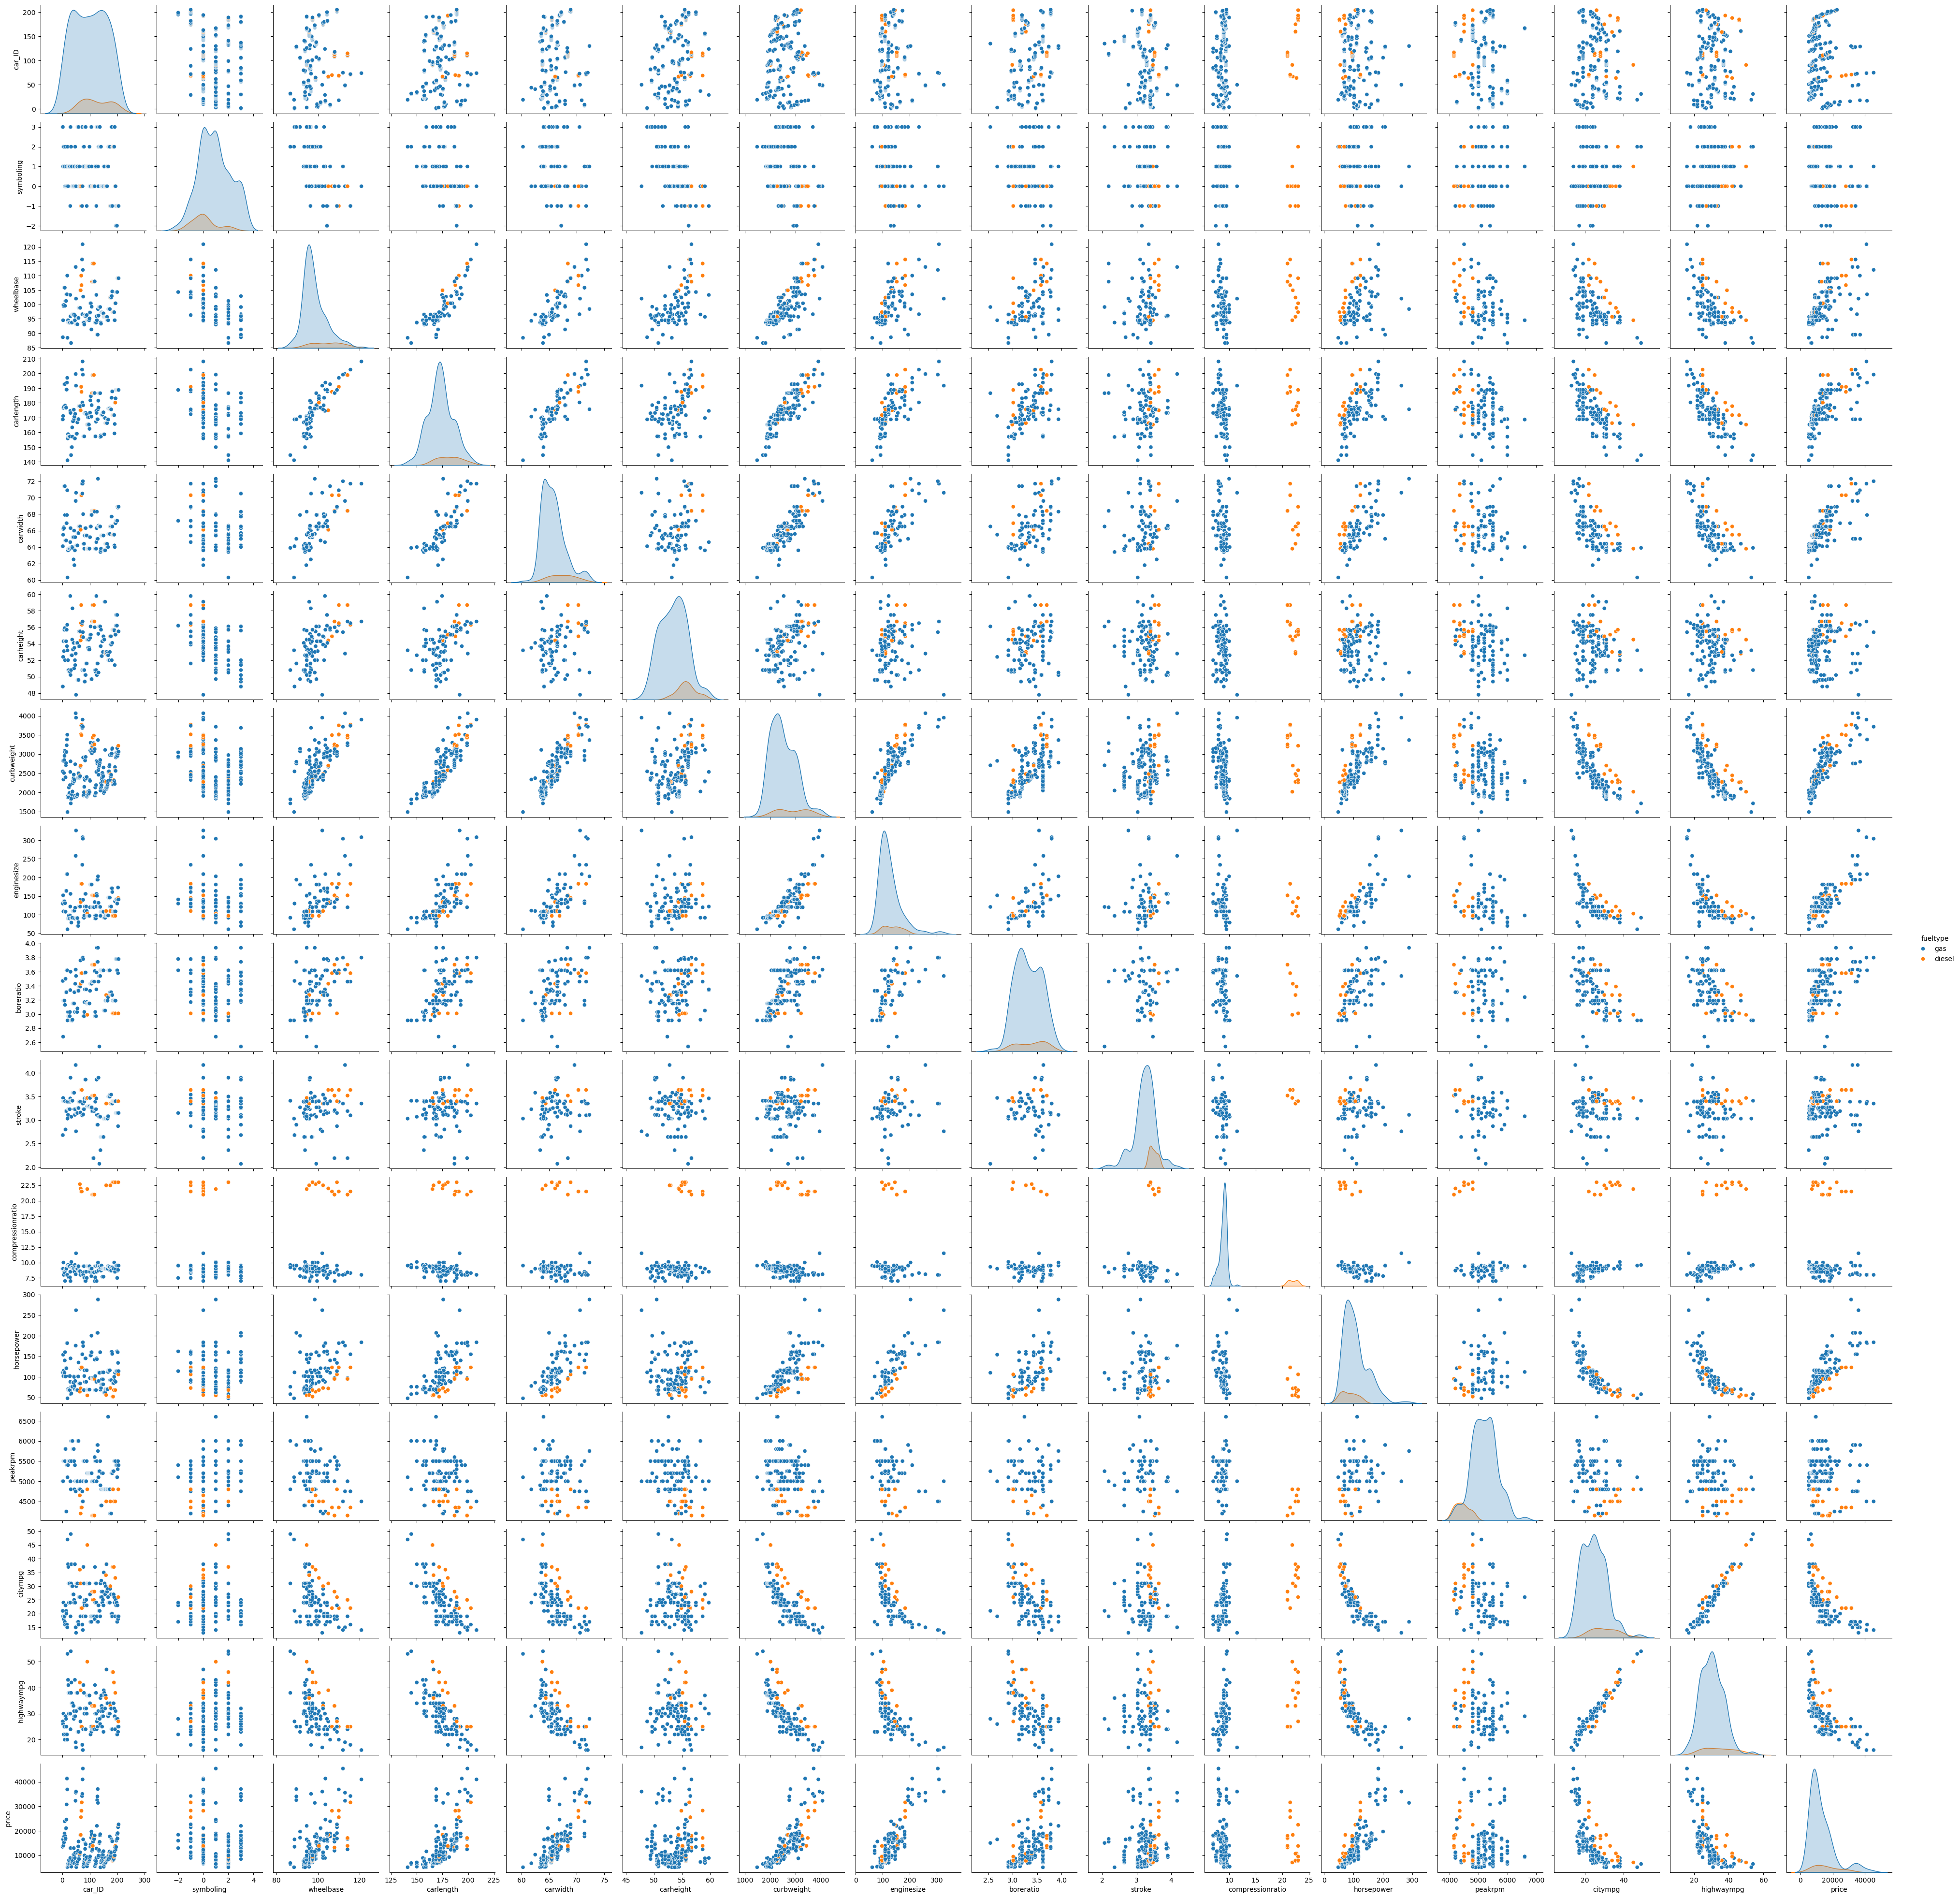

In [4]:
# データの可視化
sns.pairplot(df, hue="fueltype")
plt.show()

## データの整形
ダウンロードしたままの形出は，ニューラルネットワークへ直接入力を行うことができない。ここでは入力できる形へデータを整形する。

### 予測に意味をなさないデータの除外
読み込んだデータには，車の名称など，直接的に価格に結びつきにくいデータが含まれている。そういったデータを除外する。

※言語モデルを用いて「ポルシェだから高そう」や「高級そうな車種名だ」といった情報を加えたい場合，話は別
※単純に数値かする上でも，車種名を省いてメーカー名のみ抽出すれば情報として有意義かもしれない

In [5]:
# 学習から除外する列を指定
drop_columns = ["car_ID", 'fueltype']

# 除外
df = df.drop(drop_columns, axis=1)

### メーカー名を抽出したい場合
半角スペースで分割して，その前半を取る。

In [6]:
# 'CarName'列をメーカー名のみに置き換える
df['CarName'] = df['CarName'].str.split(' ', expand=True)[0]

### 文字列で記録されたデータの数値化
読みこんだデータには，文字列が多分に含まれている。先週扱った通り，ニューラルネットワークは「数値（数は問わない）」を入力して「数値（数は問わない）」を出力する。従って，例えば燃料タイプの"gas"や"diesel"は，何かしらの数値へ変換する必要がある。ここでは，アルファベット順にソートした名称順に0,1,2...と数値化を行う。

この例では，カテゴリ１つ１つに数値を割り当てる。

In [7]:
# 文字列と整数の対応関係を辞書で定義
mapping = {
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'eight': 8,
    'twelve': 12
}

# 'values'列を整数に置き換える
df['cylindernumber'] = df['cylindernumber'].replace(mapping)

# 結果の確認
print(df)

     symboling      CarName aspiration doornumber      carbody drivewheel  \
0            3  alfa-romero        std        two  convertible        rwd   
1            3  alfa-romero        std        two  convertible        rwd   
2            1  alfa-romero        std        two    hatchback        rwd   
3            2         audi        std       four        sedan        fwd   
4            2         audi        std       four        sedan        4wd   
..         ...          ...        ...        ...          ...        ...   
200         -1        volvo        std       four        sedan        rwd   
201         -1        volvo      turbo       four        sedan        rwd   
202         -1        volvo        std       four        sedan        rwd   
203         -1        volvo      turbo       four        sedan        rwd   
204         -1        volvo      turbo       four        sedan        rwd   

    enginelocation  wheelbase  carlength  carwidth  ...  enginesize  \
0   

C:\Users\Yusaku\AppData\Local\Temp\ipykernel_9856\3386444880.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cylindernumber'] = df['cylindernumber'].replace(mapping)


この例では，アルファベット順にソートした名称順に0,1,2...と数値化を行う。カテゴリデータ１つ１つを深く考えたくない場合はこちら

In [ ]:
# 列に対してループ
for column in df.columns:
    
    # 列名称とデータ型を表示
    print(f"-----------------------------------------")
    print(f"col name: {column}, dtype: {df[column].dtype}")

    # ユニークな値のリストを表示
    print(f"unique values:{df[column].unique()}")
    
    # object型の列に対しては，ユニークな値を0始まりの整数に置換
    if df[column].dtype == "object":
        df[column] = pd.Categorical(df[column])
        df[column] = df[column].cat.codes
        print(f"convert:{df[column].unique()}")


-----------------------------------------
col name: symboling, dtype: int64
unique values:[ 3  1  2  0 -1 -2]
-----------------------------------------
col name: CarName, dtype: object
unique values:['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'maxda' 'mazda' 'buick' 'mercury' 'mitsubishi' 'Nissan' 'nissan'
 'peugeot' 'plymouth' 'porsche' 'porcshce' 'renault' 'saab' 'subaru'
 'toyota' 'toyouta' 'vokswagen' 'volkswagen' 'vw' 'volvo']
convert:[ 1  2  3  5  6  7  8  9 10 11  4 12 13  0 14 15 16 18 17 19 20 21 22 23
 24 25 27 26]
-----------------------------------------
col name: aspiration, dtype: object
unique values:['std' 'turbo']
convert:[0 1]
-----------------------------------------
col name: doornumber, dtype: object
unique values:['two' 'four']
convert:[1 0]
-----------------------------------------
col name: carbody, dtype: object
unique values:['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
convert:[0 2 3 4 1]
---------------------------------

### データの数値レンジの正規化
今回のデータにおいては，燃料タイプは0-1で，重量は2548-3062の範囲で分布している。
これらのデータの最大値と最小値の差は，1と514で，このままモデルに入力を行った場合，このバランスを取るために訓練のリソース消費される。
意図的に何かのデータを重視したい場合を除いては，これらの値は同じスケールに統一したほうがよい。
そういった処理としてMin-Max normalization という，最小値を0，最大値を1で統一する正規化手法が存在する。

In [9]:
for column in df.columns:
    print(f"col name: {column}, min: {df[column].min()}, max: {df[column].max()}")
    if column != "price":
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

col name: symboling, min: -2, max: 3
col name: CarName, min: 0, max: 27
col name: aspiration, min: 0, max: 1
col name: doornumber, min: 0, max: 1
col name: carbody, min: 0, max: 4
col name: drivewheel, min: 0, max: 2
col name: enginelocation, min: 0, max: 1
col name: wheelbase, min: 86.6, max: 120.9
col name: carlength, min: 141.1, max: 208.1
col name: carwidth, min: 60.3, max: 72.3
col name: carheight, min: 47.8, max: 59.8
col name: curbweight, min: 1488, max: 4066
col name: enginetype, min: 0, max: 6
col name: cylindernumber, min: 2, max: 12
col name: enginesize, min: 61, max: 326
col name: fuelsystem, min: 0, max: 7
col name: boreratio, min: 2.54, max: 3.94
col name: stroke, min: 2.07, max: 4.17
col name: compressionratio, min: 7.0, max: 23.0
col name: horsepower, min: 48, max: 288
col name: peakrpm, min: 4150, max: 6600
col name: citympg, min: 13, max: 49
col name: highwaympg, min: 16, max: 54
col name: price, min: 5118.0, max: 45400.0


### 整形したデータの再可視化
再可視化により，以下の効果が確認できる。
1. 有効活用できていなかったデータが使えるように
1. 

In [ ]:
# 整形したデータの再可視化
sns.pairplot(df, hue="cylindernumber")
plt.show()

In [ ]:
df